In [217]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import matplotlib.pylab as pylab

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Working with time series using `statsmodels`

## Define helpers

In [2]:
def plot_series(series, labels = None, title = None, lw = 1, alpha = .7):
    
    if type(series) != list:
        
        plt.figure(figsize = (15, 6))
        plt.plot(series, label = labels, lw = lw)
        plt.legend()
        plt.title(title)
        plt.xticks(rotation = 45)
        plt.plot()
    
    else:
        
        plt.figure(figsize = (15, 6))
        
        if type(labels) != list:
            labels = [x for x in range(len(series))]
            
        for serie, label in zip(series, labels):
            
            plt.plot(serie, label = label, alpha = alpha, lw = lw)
        
        plt.xticks(rotation = 45)
        plt.legend()
        plt.title(title)
        plt.plot()

In [150]:
def report_adf(series, threshold = .05):
    
    result = adfuller(series)
    labels = ['Statistic', 'p-val', 'Number of lags', 'n']
    
    print('_' * 50)
    print('\nAugmented Dickey-Fuller test\n')
    print(f'{labels[0]:15}: {result[0]: 11.5f}')
    print(f'{labels[1]:15}: {result[1]: 11.5f}')
    print(f'{labels[2]:15}: {result[2]: 5}')
    print(f'{labels[3]:15}: {result[3]: 5}\n')
    print('-' * 50)
    print('\nH_0: The data is non-stationary.')
    print(f'\nReject NULL at p <= {threshold}?\n{result[1] <= threshold}\n')
    print('_' * 50)

## ARIMA

There are two types of **ARIMA** models:

* Seasonal 
* Non-seasonal

### Non-seasonal ARIMA

is also known as ARIMA(p, d, q), where:

- **p** is a auto-regressive component - the no. of lag observations incl. in the model


- **d** is a differencing component. Number of times that the raw observations are differenced.
    It subtracts an observation from the observation at the previous time step to make the data stationary.


- **q** is the moving average portion of the model - the size of the MA window; aka the order of moving average.

_

To test for the stationarity of the data we can use **ADF** - Augmented Dickey-Fuller test.

To "stationarize" your data you can perform **differencing**. Differencing can be expressed as follows in `pandas` code:

`data['differenced'] = data['original'] - data['original'].shift(1)`

If your data is still non-stationary after this transformation, you can repeat the operation to get the - so called - ***second difference*** and so on. 

Remember that each difference makes you loose one row of data!

To identify **AR** model PACF is often used.

For **MA** model ACF rather than PACF is used.


### Seasonal ARIMA

contains additional terms: **P, D** and **Q** (all capitalized).

### Get, examine and transform the data

In [10]:
# We'll use `monthly milk production` data:
data = pd.read_csv(r'https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv')

In [11]:
data.head()

,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [12]:
data.columns = ['month', 'milk']

In [15]:
data = data.set_index(pd.to_datetime(data.month), drop = True).drop('month', axis = 1)

In [16]:
# Sanity check
data.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


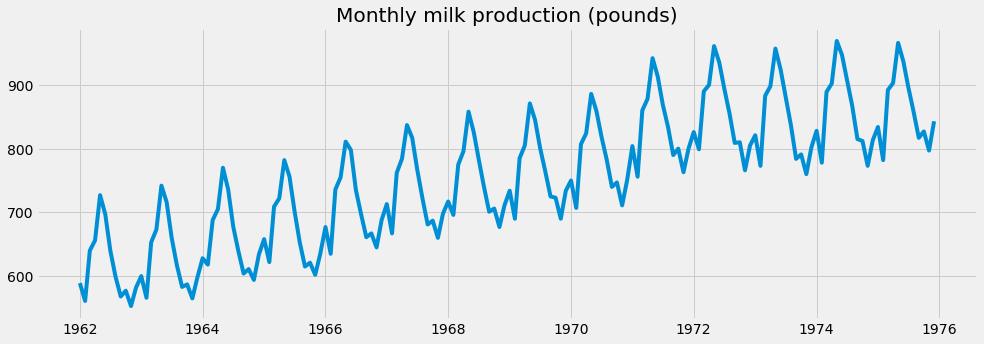

In [18]:
# Plot the series
plt.figure(figsize = (15, 5))
plt.plot(data.milk)
plt.title('Monthly milk production (pounds)')
plt.show()

The data seems to have a strong trend and seasonality.

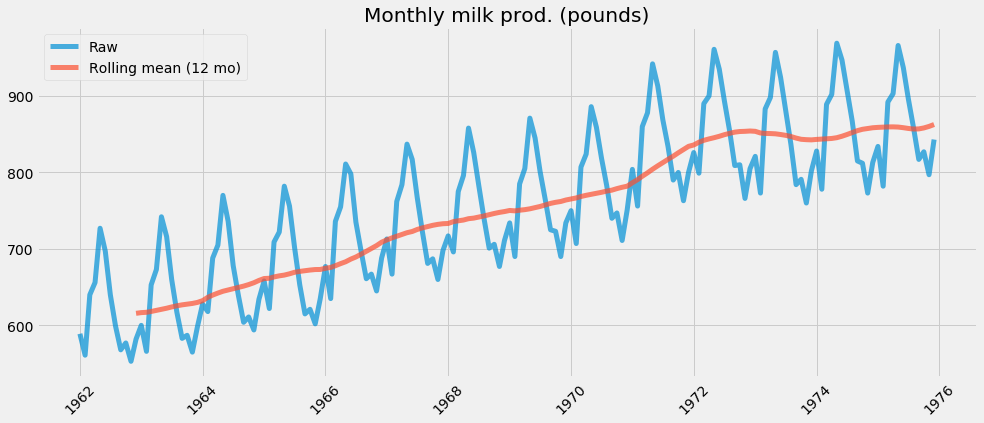

In [20]:
# Let's plot 12 month MA against the obs. to see the trend
plot_series([data.milk, data.milk.rolling(12).mean()], 
            ['Raw', 'Rolling mean (12 mo)'], 
            'Monthly milk prod. (pounds)', 
            lw = 5)

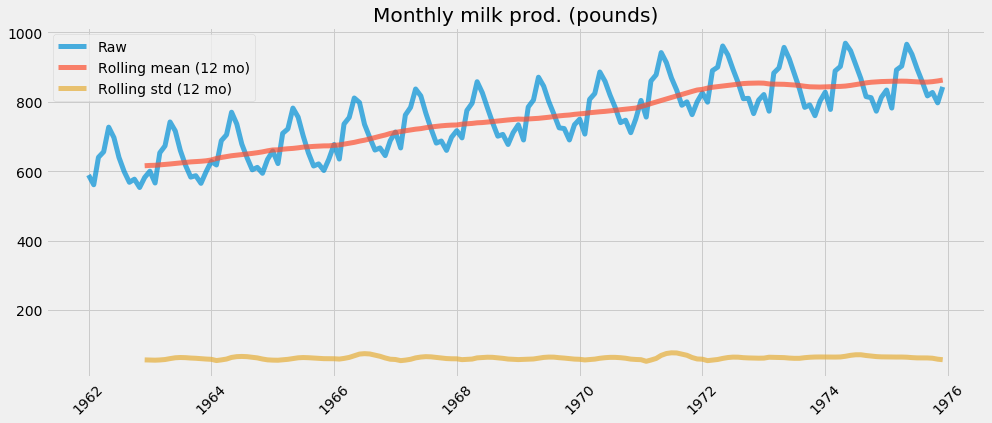

In [24]:
# Let's add std to the plot
# Let's plot 12 month MA against the obs. to see the trend
plot_series([data.milk, data.milk.rolling(12).mean(), data.milk.rolling(12).std()], 
            ['Raw', 'Rolling mean (12 mo)', 'Rolling std (12 mo)'], 
            'Monthly milk prod. (pounds)', 
            lw = 5)

In [25]:
# Get seasonal decomposition
decomp = seasonal_decompose(data.milk)

[]

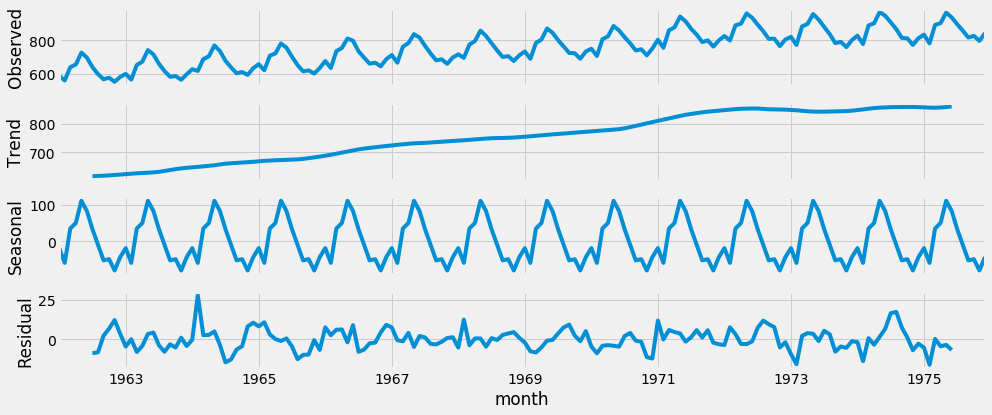

In [31]:
pylab.rcParams['figure.figsize'] = (14, 6)
decomp.plot()
plt.plot()

## Test stationarity

Augmented Dickey Fuller test ([Wikipedia](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), [Machinelearningplus](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)) tests the null hypothesis that the data is not stationary.

In [35]:
# Perform Augmented Dickey-Fuller test
adf = adfuller(data.milk)

In [36]:
adf

(-1.3038115874221312,
 0.6274267086030308,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [151]:
report_adf(data.milk)

__________________________________________________

Augmented Dickey-Fuller test

Statistic      :    -1.30381
p-val          :     0.62743
Number of lags :    13
n              :   154

--------------------------------------------------

H_0: The data is non-stationary.

Reject NULL at p <= 0.05?
False

__________________________________________________


As we can see ADF returns a result that is not significant at the customary level ($p \leq .05$)

## Apply differencing

In [142]:
# Apply the first difference
data['diff_1'] = data.milk - data.milk.shift(1)

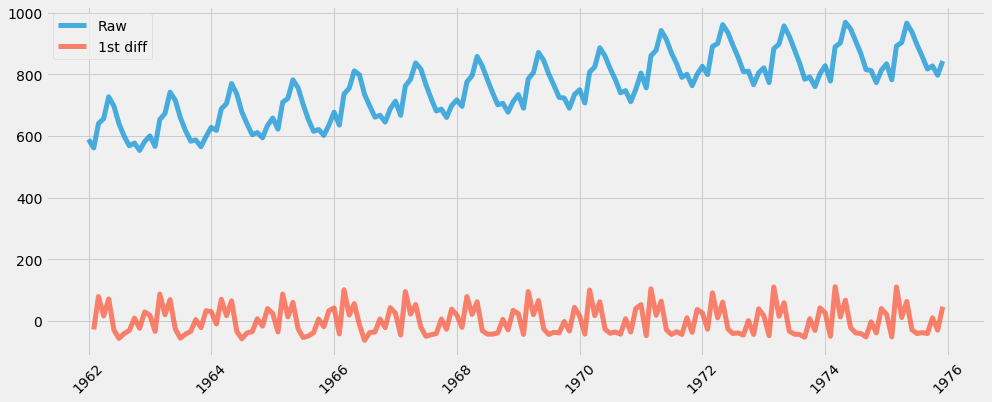

In [144]:
# Plot it
plot_series([data.milk, data.diff_1], ['Raw', '1st diff'], lw = 5)

In [152]:
# Let's re-run ADF
report_adf(data.diff_1.dropna(axis = 0))

__________________________________________________

Augmented Dickey-Fuller test

Statistic      :    -3.05500
p-val          :     0.03007
Number of lags :    14
n              :   152

--------------------------------------------------

H_0: The data is non-stationary.

Reject NULL at p <= 0.05?
True

__________________________________________________


Data seems stationary now. Let's see the second diff anyway

In [156]:
# Second diff
data['diff_2'] = data.diff_1 - data.diff_1.shift(1)

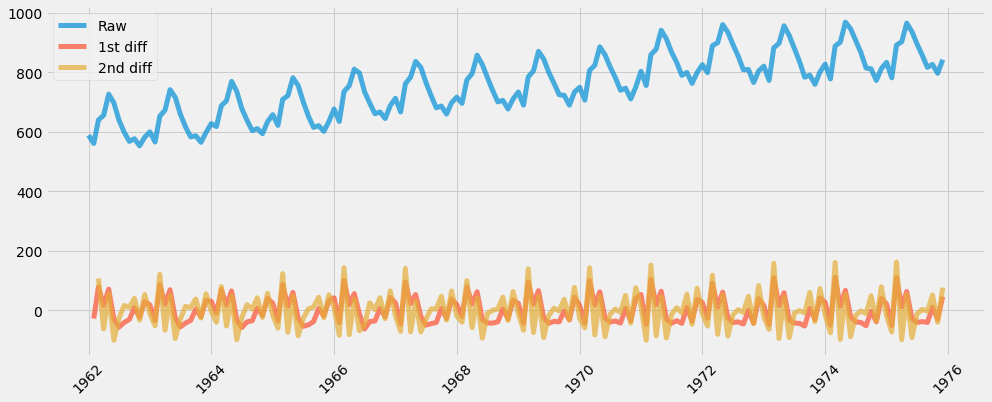

In [157]:
plot_series([data.milk, data.diff_1, data.diff_2], ['Raw', '1st diff', '2nd diff'], lw = 5)

In [155]:
report_adf(data.diff_2.dropna(axis = 0))

__________________________________________________

Augmented Dickey-Fuller test

Statistic      :   -14.32787
p-val          :     0.00000
Number of lags :    11
n              :   154

--------------------------------------------------

H_0: The data is non-stationary.

Reject NULL at p <= 0.05?
True

__________________________________________________


ADF statistic went significantly down.

### Seasonal difference

In [158]:
data['diff_season'] = data.milk - data.milk.shift(12)

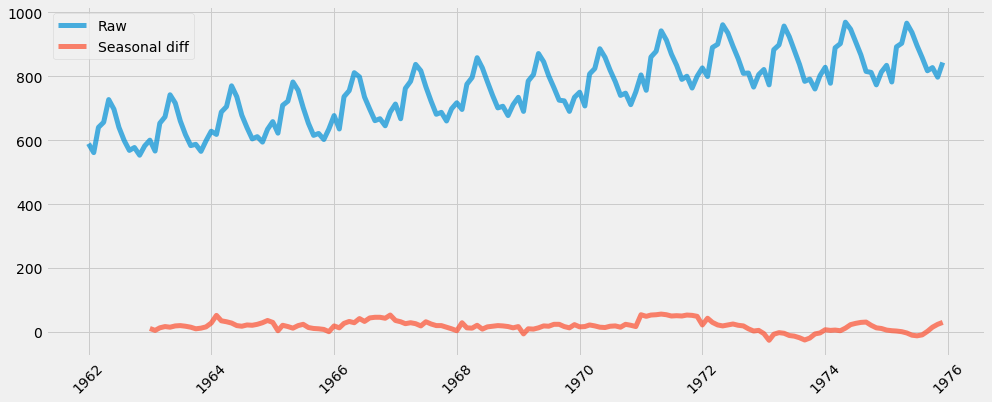

In [160]:
# Let's plot it!
plot_series([data.milk, data.diff_season], ['Raw', 'Seasonal diff'], lw = 5)

In [162]:
# Doesn't look like it helps enough, but let's see
report_adf(data.diff_season.dropna(axis = 0))

__________________________________________________

Augmented Dickey-Fuller test

Statistic      :    -2.33542
p-val          :     0.16080
Number of lags :    12
n              :   143

--------------------------------------------------

H_0: The data is non-stationary.

Reject NULL at p <= 0.05?
False

__________________________________________________


### Seasonal first difference

In [163]:
data['diff_season_first'] = data.diff_1 - data.diff_1.shift(12)

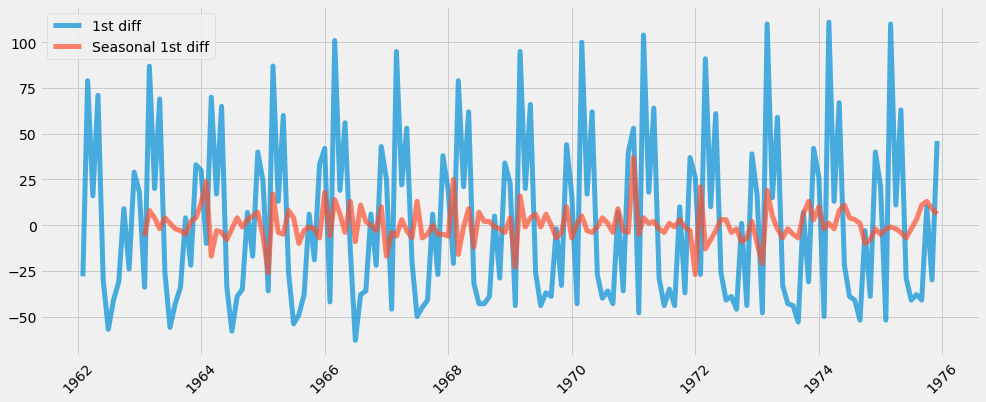

In [169]:
plot_series([data.diff_1, data.diff_season_first], ['1st diff', 'Seasonal 1st diff'], lw = 5)

In [168]:
report_adf(data.diff_season_first.dropna())

__________________________________________________

Augmented Dickey-Fuller test

Statistic      :    -5.03800
p-val          :     0.00002
Number of lags :    11
n              :   143

--------------------------------------------------

H_0: The data is non-stationary.

Reject NULL at p <= 0.05?
True

__________________________________________________


## ACF and PACF

[]

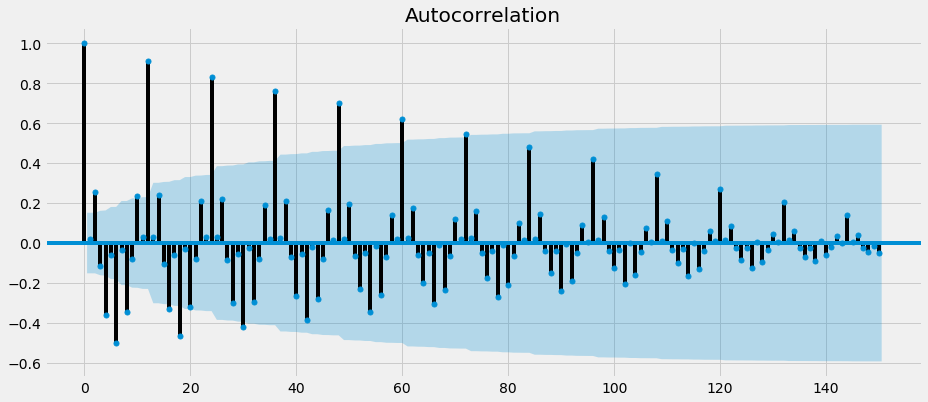

In [183]:
# Plot autocorr for first diff
plot_acf(data.diff_1.dropna(), lags = 150)
plt.plot()

[]

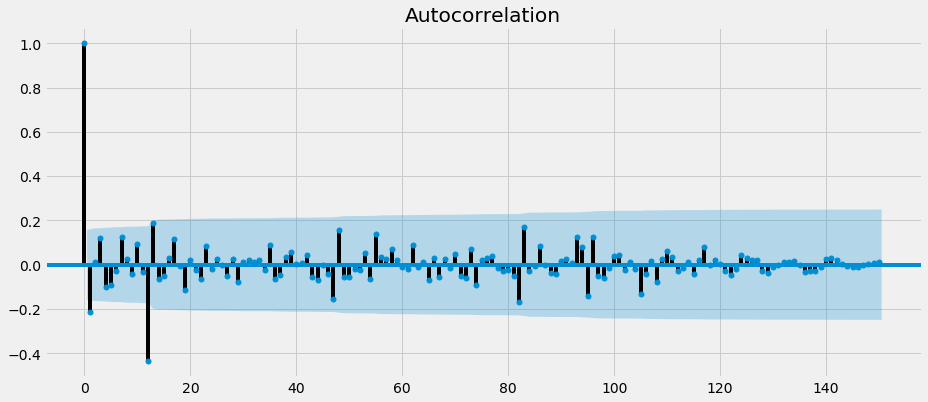

In [184]:
# Plot autocorr for seasonal first diff
plot_acf(data.diff_season_first.dropna(), lags = 150)
plt.plot()

[]

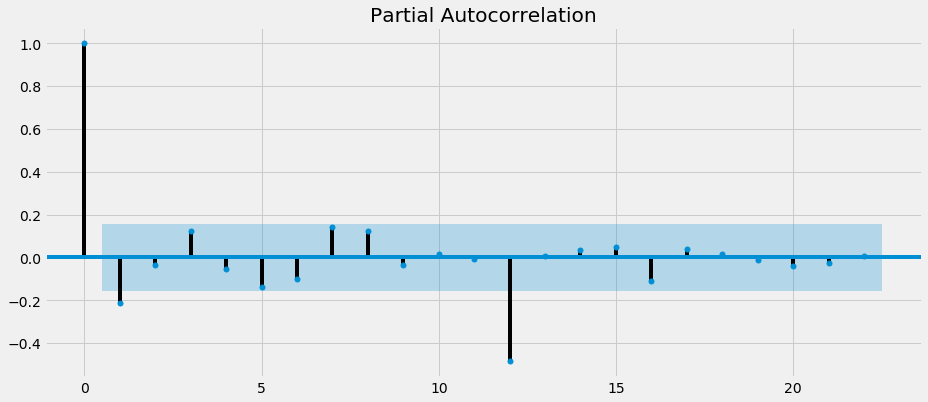

In [190]:
# Plot autocorr for seasonal first diff
plot_pacf(data.diff_season_first.dropna())
plt.plot()

### Using seasonal ARIMA

In [197]:
model = sm.tsa.statespace.SARIMAX(data.milk, 
                                 order = (0, 1, 0),
                                 seasonal_order = (1, 1, 1, 12))

C:\Users\aleksander.molak\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [198]:
sarimax = model.fit()

In [199]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               milk   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Sun, 05 Jan 2020   AIC                           1074.131
Time:                                    10:57:09   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102     -5.762      0.000      -0.785      -0.387
sigma2        55.5118      5.356     10.365      0.000      45.015      66.009
===================================================================================
Ljung-Box (Q):                       33.48   Jarque-Bera (JB):                32.04
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.77
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

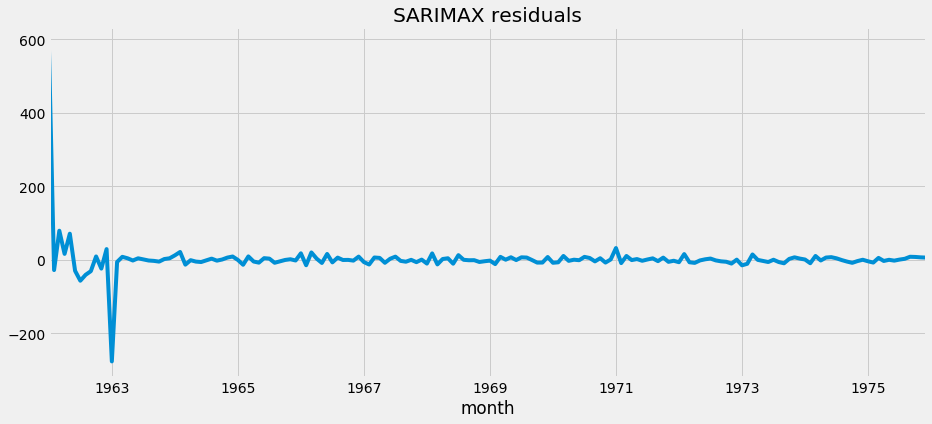

In [202]:
# Examine residuals
sarimax.resid.plot(title = 'SARIMAX residuals')

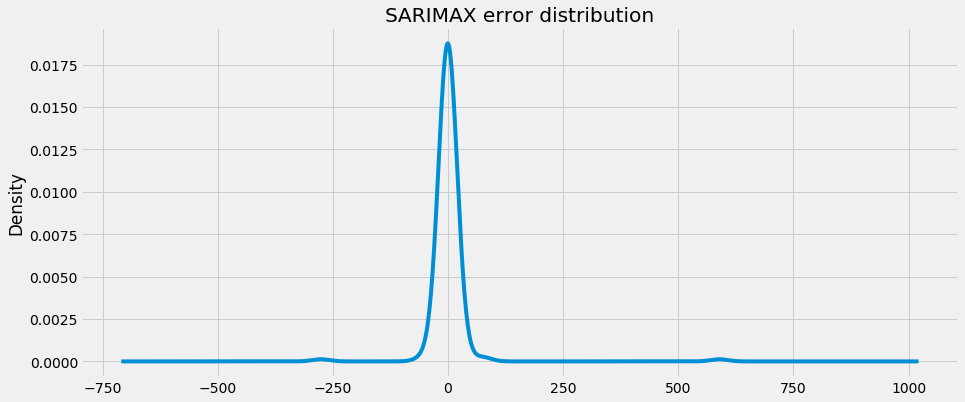

In [205]:
# Error distr
sarimax.resid.plot(kind = 'kde', title = 'SARIMAX error distribution')

### Make predictions

In [206]:
len(data)

168

In [213]:
data['forecast'] = sarimax.predict(start = 130, end = 168)

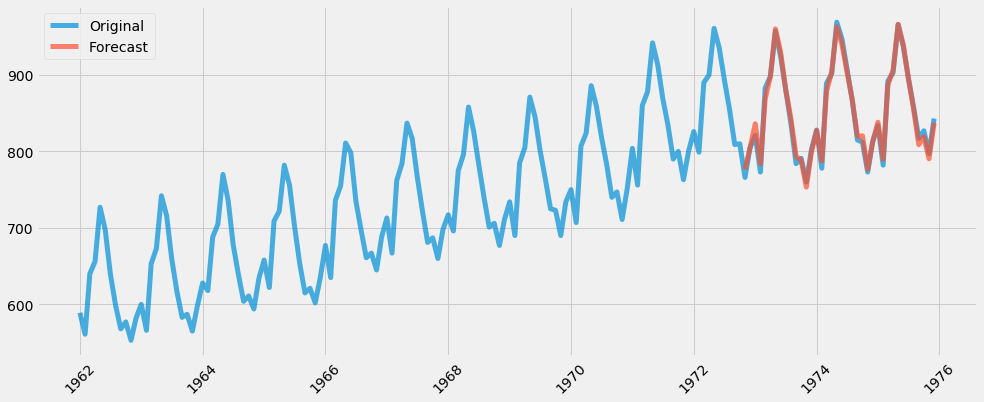

In [214]:
plot_series([data.milk, data.forecast], ['Original', 'Forecast'], lw = 5)

In [215]:
# Add more vals to the df
data.tail()

,milk,diff_1,diff_2,diff_season,diff_season_first,forecast
month,,,,,,
1975-08-01,858,-38.0,3.0,-9.0,3.0,855.358648
1975-09-01,817,-41.0,-3.0,2.0,11.0,808.841372
1975-10-01,827,10.0,51.0,15.0,13.0,819.323185
1975-11-01,797,-30.0,-40.0,24.0,9.0,790.427530
1975-12-01,843,46.0,76.0,30.0,6.0,837.063622


In [231]:
# Create aditional rows with timestamp
future_ids = [data.index[-1] + DateOffset(months = x) for x in range(1, 24)]

In [234]:
# Create an empty future df
future_df = pd.DataFrame(index = future_ids, columns = data.columns)

In [235]:
future_df.head()

,milk,diff_1,diff_2,diff_season,diff_season_first,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
# Concatenate
all_data = pd.concat([data, future_df])

In [248]:
# Forecast
all_data['forecast'] = sarimax.predict(start = 130, end = 192)

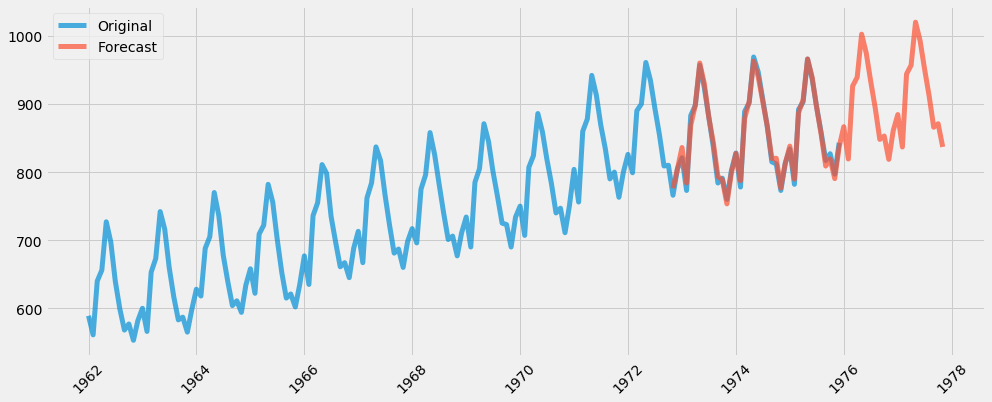

In [249]:
# Plot
plot_series([all_data.milk, all_data.forecast], ['Original', 'Forecast'], lw = 5)